### Overview 
The solution first trains multiple strong image-only models, such as EfficientNet and ConvNeXt. Then features from these models are used to find similar images from the previous competition dataset, and matched metadata like Age, Breed, and AdoptionSpeed are added. After that, Bayesian Ridge stacking is applied on the out-of-fold predictions, and previous competition meta. Finally, a weighted ensemble of the stacked predictions and a simple average is used for the final prediction.
### Reason for good performance
The data from the previous competition helps by providing additional information for Pet2 images that are visually similar. When a Pet2 image matches a Pet1 image from the previous competition, metadata such as Age, Breed, Fee, PhotoAmt, Description length, and AdoptionSpeed can be added to the current training set. This extra information allows the model to make more informed predictions

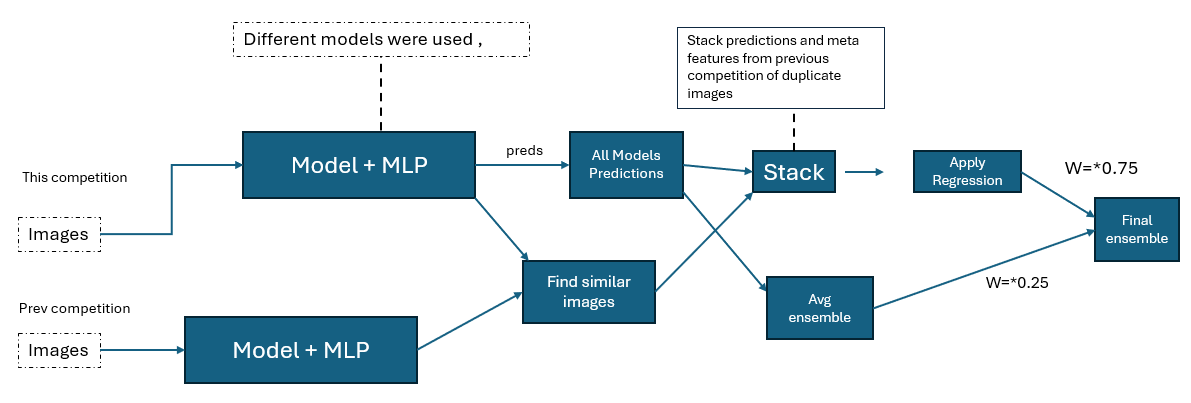

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm
import albumentations as A
from tqdm.auto import tqdm
tqdm.pandas()
import os
import gc
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.linear_model import BayesianRidge
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Configuration
N_FOLDS = 5
EPOCHS = 5
SAVE_DIR = "saved_5th_place"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================================
# PART 0: DATA LOADING
# ============================================================================
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)
# DATA LOADING

BASE_PATH = "inputs/"
# Pet2
train = pd.read_csv(f'{BASE_PATH}train.csv')
test = pd.read_csv(f'{BASE_PATH}test.csv')
train['file'] = train['Id'].map(lambda x: f'{BASE_PATH}train/{x}.jpg')
test['file'] = test['Id'].map(lambda x: f'{BASE_PATH}test/{x}.jpg')
prev_train_dir = f'{BASE_PATH}pet_adopt/train_images/'
prev_test_dir = f'{BASE_PATH}pet_adopt/test_images/'
# Pet1 , this is the previous competition data of petfinder
prev_train = pd.read_csv(f'{BASE_PATH}pet_adopt/train/train.csv')
prev_test = pd.read_csv(f'{BASE_PATH}pet_adopt/test/test.csv')
prev_train['file'] = prev_train['PetID'].map(lambda x: f"{prev_train_dir}/{x}-1.jpg")
prev_test['file'] = prev_test['PetID'].map(lambda x: f"{prev_test_dir}/{x}-1.jpg")
prev_train = prev_train[prev_train['file'].map(os.path.exists)].reset_index(drop=True)
prev_test = prev_test[prev_test['file'].map(os.path.exists)].reset_index(drop=True)

print(f"Pet2 Train: {len(train)}, Test: {len(test)}")
print(f"Pet1 Train: {len(prev_train)}, Test: {len(prev_test)}")

Device: cuda

LOADING DATA
Pet2 Train: 9912, Test: 8
Pet1 Train: 2020, Test: 2154


In [ ]:
# ============================================================================
# PART 1: FIND DUPLICATE IMAGES 
# ============================================================================
print("\n" + "="*80)
print("FINDING DUPLICATE IMAGES")
print("="*80)

import imagehash

def compute_hash(path):
    try:
        return str(imagehash.average_hash(Image.open(path).convert('RGB')))
    except:
        return None

print("Computing hashes...")
train['hash'] = train['file'].progress_apply(compute_hash)

# Find duplicates and assign group IDs
hash_to_group = {}
group_id = 0
for h in train['hash'].unique():
    if pd.notna(h):
        hash_to_group[h] = group_id
        group_id += 1

train['group'] = train['hash'].map(hash_to_group)

# Count duplicates
hash_counts = train['hash'].value_counts()
n_duplicates = (hash_counts > 1).sum()
print(f"Found {n_duplicates} duplicate hash groups")
print(f"Total unique groups: {train['group'].nunique()}")


FINDING DUPLICATE IMAGES
Computing hashes...


  0%|          | 0/9912 [00:00<?, ?it/s]

Found 25 duplicate hash groups
Total unique groups: 9885


In [ ]:
# ============================================================================
# PART 2: DATASET AND MODEL (NO METADATA!)
# ============================================================================

class ImageOnlyDataset(Dataset):
    """Dataset that uses ONLY images, no metadata"""
    def __init__(self, paths, targets, transform=None):
        self.paths = paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.paths[idx]).convert('RGB'))
        
        # Cut long side to make square 
        h, w = img.shape[:2]
        if h > w:
            img = img[(h-w)//2:(h-w)//2+w, :]
        elif w > h:
            img = img[:, (w-h)//2:(w-h)//2+h]
        
        if self.transform:
            img = self.transform(image=img)["image"]
        
        img = np.transpose(img / 255.0, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(img, dtype=torch.float),
            'target': torch.tensor(self.targets[idx], dtype=torch.float)
        }

def get_transforms(size=224, train=True):
    if train:
        return A.Compose([A.Resize(size, size), A.HorizontalFlip(p=0.5), A.Rotate(limit=15, p=0.5)])
    return A.Compose([A.Resize(size, size)])
class ImageOnlyModel(nn.Module):
    """Simple model without metadata"""
    def __init__(self, name, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=pretrained, num_classes=1)
    
    def forward(self, img):
        return self.backbone(img).squeeze(-1)

In [ ]:
# ============================================================================
# PART 3: TRAIN SINGLE MODELS WITH GROUPKFOLD
# ============================================================================

def train_single_model(name, train_df, size, lr, bs, loss_type='bce'):
    print(f"\n{'='*70}")
    print(f"Training: {name} | Loss: {loss_type.upper()}")
    print(f"{'='*70}")
    
    oof = np.zeros(len(train_df))
    
    # Use GroupKFold to keep duplicates together
    gkf = GroupKFold(n_splits=N_FOLDS)
    splits = list(gkf.split(train_df, train_df['Pawpularity'], train_df['group']))
    
    for fold, (tr_idx, val_idx) in enumerate(splits):
        print(f"\nFold {fold+1}/{N_FOLDS}")
        
        tr_paths = train_df.iloc[tr_idx]['file'].values
        val_paths = train_df.iloc[val_idx]['file'].values
        
        if loss_type == 'bce':
            tr_tgt = train_df.iloc[tr_idx]['Pawpularity'].values / 100.0
            val_tgt_norm = train_df.iloc[val_idx]['Pawpularity'].values / 100.0
            criterion = nn.BCEWithLogitsLoss()
        else:  # mse
            tr_tgt = train_df.iloc[tr_idx]['Pawpularity'].values
            val_tgt_norm = train_df.iloc[val_idx]['Pawpularity'].values
            criterion = nn.MSELoss()
        
        val_tgt = train_df.iloc[val_idx]['Pawpularity'].values
        
        print(f"  Train: {len(tr_paths)}, Val: {len(val_paths)}")
        
        train_ds = ImageOnlyDataset(tr_paths, tr_tgt, get_transforms(size, True))
        val_ds = ImageOnlyDataset(val_paths, val_tgt_norm, get_transforms(size, False))
        
        train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=bs*2, shuffle=False, num_workers=0)
        
        model = ImageOnlyModel(name, True).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=3)
        
        best_rmse = float('inf')
        best_preds = None
        patience = 0
        
        for epoch in range(EPOCHS):
            # Train
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                opt.zero_grad()
                logits = model(batch['image'].to(device))
                loss = criterion(logits, batch['target'].to(device))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()
            sched.step()
            
            # Validate
            model.eval()
            preds = []
            with torch.no_grad():
                for batch in val_loader:
                    logits = model(batch['image'].to(device))
                    if loss_type == 'bce':
                        scaled = torch.sigmoid(logits) * 100.0
                    else:
                        scaled = logits
                    preds.extend(scaled.cpu().numpy())
            
            preds = np.clip(preds, 1, 100)
            rmse = np.sqrt(np.mean((val_tgt - preds) ** 2))
            print(f"  Epoch {epoch+1} RMSE: {rmse:.4f}", end='')
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_preds = preds.copy()
                torch.save(model.state_dict(), f"{SAVE_DIR}/{name}_fold{fold}.pth")
                patience = 0
                print(" <- BEST")
            else:
                patience += 1
                print(f" (patience={patience}/3)")
                if patience >= 3:
                    print("  Early stopping!")
                    break
        
        oof[val_idx] = best_preds
        print(f"Fold {fold+1} Best RMSE: {best_rmse:.4f}")
        
        del model, opt, sched
        torch.cuda.empty_cache()
        gc.collect()
    
    overall_rmse = np.sqrt(np.mean((train_df['Pawpularity'].values - oof) ** 2))
    print(f"\n{name} Overall OOF RMSE: {overall_rmse:.4f}")
    return oof

# Train 2 models
configs = [
    {"name": "efficientnet_b0", "size": 224, "lr": 1e-4, "bs": 24, "loss": "bce"},
    {"name": "convnext_tiny", "size": 224, "lr": 1e-4, "bs": 32, "loss": "bce"}
]

print("\n" + "="*80)
print("STEP 1: TRAINING SINGLE MODELS (IMAGE ONLY)")
print("="*80)

single_oofs = {}
for cfg in configs:
    oof = train_single_model(cfg['name'], train, cfg['size'], cfg['lr'], cfg['bs'], cfg['loss'])
    single_oofs[cfg['name']] = oof
    train[f"oof_{cfg['name']}"] = oof


STEP 1: TRAINING SINGLE MODELS (IMAGE ONLY)

Training: efficientnet_b0 | Loss: BCE

Fold 1/5
  Train: 7929, Val: 1983


Epoch 1:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 1 RMSE: 37.3596 <- BEST


Epoch 2:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2 RMSE: 29.5765 <- BEST


Epoch 3:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3 RMSE: 27.6691 <- BEST


Epoch 4:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4 RMSE: 23.2609 <- BEST


Epoch 5:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5 RMSE: 21.8623 <- BEST
Fold 1 Best RMSE: 21.8623

Fold 2/5
  Train: 7929, Val: 1983


Epoch 1:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 1 RMSE: 38.5384 <- BEST


Epoch 2:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2 RMSE: 31.4526 <- BEST


Epoch 3:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3 RMSE: 28.0101 <- BEST


Epoch 4:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4 RMSE: 22.7455 <- BEST


Epoch 5:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5 RMSE: 21.5803 <- BEST
Fold 2 Best RMSE: 21.5803

Fold 3/5
  Train: 7930, Val: 1982


Epoch 1:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 1 RMSE: 37.7777 <- BEST


Epoch 2:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2 RMSE: 30.7201 <- BEST


Epoch 3:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3 RMSE: 27.5343 <- BEST


Epoch 4:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4 RMSE: 22.5038 <- BEST


Epoch 5:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5 RMSE: 21.6127 <- BEST
Fold 3 Best RMSE: 21.6127

Fold 4/5
  Train: 7930, Val: 1982


Epoch 1:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 1 RMSE: 37.5981 <- BEST


Epoch 2:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2 RMSE: 28.0419 <- BEST


Epoch 3:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3 RMSE: 25.7220 <- BEST


Epoch 4:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4 RMSE: 21.7502 <- BEST


Epoch 5:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5 RMSE: 20.9954 <- BEST
Fold 4 Best RMSE: 20.9954

Fold 5/5
  Train: 7930, Val: 1982


Epoch 1:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 1 RMSE: 39.8205 <- BEST


Epoch 2:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2 RMSE: 34.1934 <- BEST


Epoch 3:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3 RMSE: 30.5163 <- BEST


Epoch 4:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4 RMSE: 22.9493 <- BEST


Epoch 5:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5 RMSE: 21.2700 <- BEST
Fold 5 Best RMSE: 21.2700

efficientnet_b0 Overall OOF RMSE: 21.4663

Training: convnext_tiny | Loss: BCE

Fold 1/5
  Train: 7929, Val: 1983


Epoch 1:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.7585 <- BEST


Epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.8383 (patience=1/3)


Epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.9263 (patience=2/3)


Epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 4 RMSE: 20.7345 <- BEST


Epoch 5:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 5 RMSE: 20.7925 (patience=1/3)
Fold 1 Best RMSE: 20.7345

Fold 2/5
  Train: 7929, Val: 1983


Epoch 1:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.4479 <- BEST


Epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.6904 (patience=1/3)


Epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.4555 (patience=2/3)


Epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 4 RMSE: 20.8259 (patience=3/3)
  Early stopping!
Fold 2 Best RMSE: 20.4479

Fold 3/5
  Train: 7930, Val: 1982


Epoch 1:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 1 RMSE: 22.4969 <- BEST


Epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.9600 <- BEST


Epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.9846 (patience=1/3)


Epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 4 RMSE: 21.2282 (patience=2/3)


Epoch 5:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 5 RMSE: 21.0583 (patience=3/3)
  Early stopping!
Fold 3 Best RMSE: 20.9600

Fold 4/5
  Train: 7930, Val: 1982


Epoch 1:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.4257 <- BEST


Epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.4254 <- BEST


Epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.4571 (patience=1/3)


Epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 4 RMSE: 20.4289 (patience=2/3)


Epoch 5:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 5 RMSE: 20.4721 (patience=3/3)
  Early stopping!
Fold 4 Best RMSE: 20.4254

Fold 5/5
  Train: 7930, Val: 1982


Epoch 1:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.5528 <- BEST


Epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.4175 <- BEST


Epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.4198 (patience=1/3)


Epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 4 RMSE: 20.4141 <- BEST


Epoch 5:   0%|          | 0/248 [00:00<?, ?it/s]

  Epoch 5 RMSE: 20.4124 <- BEST
Fold 5 Best RMSE: 20.4124

convnext_tiny Overall OOF RMSE: 20.5972


In [16]:
# ============================================================================
# PART 4: EXTRACT FEATURES FOR SIMILARITY MATCHING
# ============================================================================
print("\n" + "="*80)
print("STEP 2: EXTRACTING FEATURES FOR SIMILARITY MATCHING")
print("="*80)

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=True, num_classes=0)
    
    def forward(self, x):
        return self.model(x)

def extract_features_batch(paths, model, batch_size=32, img_size=224):
    """Extract features for a list of image paths"""
    transform = get_transforms(img_size, train=False)
    features_list = []
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(paths), batch_size), desc="Extracting features"):
            batch_paths = paths[i:i+batch_size]
            batch_imgs = []
            
            for path in batch_paths:
                try:
                    img = np.array(Image.open(path).convert('RGB'))
                    h, w = img.shape[:2]
                    if h > w:
                        img = img[(h-w)//2:(h-w)//2+w, :]
                    elif w > h:
                        img = img[:, (w-h)//2:(w-h)//2+h]
                    img = transform(image=img)["image"]
                    img = np.transpose(img / 255.0, (2, 0, 1)).astype(np.float32)
                    batch_imgs.append(img)
                except:
                    # Use zero features for failed images
                    batch_imgs.append(np.zeros((3, img_size, img_size), dtype=np.float32))
            
            batch_tensor = torch.tensor(np.array(batch_imgs), dtype=torch.float).to(device)
            features = model(batch_tensor).cpu().numpy()
            features_list.append(features)
    
    return np.vstack(features_list)

feature_model = FeatureExtractor().to(device)

print("\nExtracting features for Pet2 train...")
pet2_features = extract_features_batch(train['file'].values, feature_model)

print("Extracting features for Pet1 train...")
pet1_train_features = extract_features_batch(prev_train['file'].values, feature_model, batch_size=16)

print("Extracting features for Pet1 test...")
pet1_test_features = extract_features_batch(prev_test['file'].values, feature_model, batch_size=16)

# Combine Pet1 features
pet1_features = np.vstack([pet1_train_features, pet1_test_features])
pet1_df = pd.concat([prev_train, prev_test], ignore_index=True)

print(f"\nFeature shapes:")
print(f"  Pet2: {pet2_features.shape}")
print(f"  Pet1: {pet1_features.shape}")

del feature_model
torch.cuda.empty_cache()


STEP 2: EXTRACTING FEATURES FOR SIMILARITY MATCHING

Extracting features for Pet2 train...


Extracting features:   0%|          | 0/310 [00:00<?, ?it/s]

Extracting features for Pet1 train...


Extracting features:   0%|          | 0/127 [00:00<?, ?it/s]

Extracting features for Pet1 test...


Extracting features:   0%|          | 0/135 [00:00<?, ?it/s]


Feature shapes:
  Pet2: (9912, 1280)
  Pet1: (4174, 1280)


In [17]:
# ============================================================================
# PART 5: COMPUTE SIMILARITY AND FIND MATCHES
# ============================================================================
print("\n" + "="*80)
print("STEP 3: COMPUTING COSINE SIMILARITY")
print("="*80)

# Compute cosine similarity in batches to avoid memory issues
print("Computing similarity matrix...")
similarity_threshold = 0.95

matches = []
for i in tqdm(range(len(pet2_features)), desc="Finding matches"):
    similarities = cosine_similarity([pet2_features[i]], pet1_features)[0]
    max_sim_idx = similarities.argmax()
    max_sim = similarities[max_sim_idx]
    
    if max_sim > similarity_threshold:
        matches.append({
            'pet2_idx': i,
            'pet1_idx': max_sim_idx,
            'similarity': max_sim
        })

matches_df = pd.DataFrame(matches)
print(f"\nFound {len(matches_df)} matches above threshold {similarity_threshold}")

# Add matched Pet1 metadata to train
train['matched'] = 0
train['pet1_idx'] = -1
train['similarity'] = 0.0

for _, row in matches_df.iterrows():
    pet2_idx = row['pet2_idx']
    pet1_idx = row['pet1_idx']
    train.loc[pet2_idx, 'matched'] = 1
    train.loc[pet2_idx, 'pet1_idx'] = pet1_idx
    train.loc[pet2_idx, 'similarity'] = row['similarity']

# Merge Pet1 metadata
pet1_meta_cols = ['Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                  'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
                  'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt',
                  'Description', 'AdoptionSpeed']

for col in pet1_meta_cols:
    train[f'pet1_{col}'] = np.nan

for _, row in matches_df.iterrows():
    pet2_idx = row['pet2_idx']
    pet1_idx = int(row['pet1_idx'])
    for col in pet1_meta_cols:
        if col in pet1_df.columns:
            train.loc[pet2_idx, f'pet1_{col}'] = pet1_df.loc[pet1_idx, col]

# Create text length feature
train['pet1_TextLength'] = train['pet1_Description'].fillna('').str.len()

print(f"Matched samples: {train['matched'].sum()}")
print(f"AdoptionSpeed distribution in matched:")
print(train[train['matched']==1]['pet1_AdoptionSpeed'].value_counts().sort_index())


STEP 3: COMPUTING COSINE SIMILARITY
Computing similarity matrix...


Finding matches:   0%|          | 0/9912 [00:00<?, ?it/s]


Found 441 matches above threshold 0.95
Matched samples: 441
AdoptionSpeed distribution in matched:
pet1_AdoptionSpeed
0.0     4
1.0    33
2.0    47
3.0    45
4.0    88
Name: count, dtype: int64


In [ ]:
# ============================================================================
# PART 6: BAYESIAN RIDGE STACKING
# ============================================================================
print("\n" + "="*80)
print("STEP 4: BAYESIAN RIDGE STACKING")
print("="*80)

# Prepare features for stacking
oof_cols = [f"oof_{cfg['name']}" for cfg in configs]
X_stack = train[oof_cols].values

# Train BayesianRidge with 4-fold (as per 5th place)
from sklearn.model_selection import KFold

stacking_folds = 4
train['stacked_pred'] = 0.0

kf = KFold(n_splits=stacking_folds, shuffle=True, random_state=42)

for fold, (tr_idx, val_idx) in enumerate(kf.split(train)):
    print(f"\nStacking Fold {fold+1}/{stacking_folds}")
    
    X_tr = X_stack[tr_idx]
    y_tr = train.iloc[tr_idx]['Pawpularity'].values
    X_val = X_stack[val_idx]
    y_val = train.iloc[val_idx]['Pawpularity'].values
    
    stacker = BayesianRidge()
    stacker.fit(X_tr, y_tr)
    
    val_pred = stacker.predict(X_val)
    val_pred = np.clip(val_pred, 1, 100)
    train.loc[val_idx, 'stacked_pred'] = val_pred
    
    rmse = np.sqrt(np.mean((y_val - val_pred) ** 2))
    print(f"  Fold {fold+1} RMSE: {rmse:.4f}")
    
    # Save stacker
    import joblib
    joblib.dump(stacker, f"{SAVE_DIR}/stacker_fold{fold}.pkl")

stacked_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['stacked_pred']) ** 2))
print(f"\nStacked OOF RMSE: {stacked_rmse:.4f}")

#  create simple average for comparison
train['avg_pred'] = train[oof_cols].mean(axis=1)
avg_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['avg_pred']) ** 2))
print(f"Simple Average RMSE: {avg_rmse:.4f}")


STEP 4: BAYESIAN RIDGE STACKING

Stacking Fold 1/4
  Fold 1 RMSE: 20.0216

Stacking Fold 2/4
  Fold 2 RMSE: 19.3977

Stacking Fold 3/4
  Fold 3 RMSE: 19.1351

Stacking Fold 4/4
  Fold 4 RMSE: 19.8936

Stacked OOF RMSE: 19.6153
Simple Average RMSE: 19.6468


In [19]:
# ============================================================================
# PART 7: POST-PROCESSING WITH ADOPTIONSPEED (5 MODELS)
# ============================================================================
print("\n" + "="*80)
print("STEP 5: POST-PROCESSING BY ADOPTIONSPEED")
print("="*80)

# Create features for post-processing
pp_features = ['stacked_pred', 'pet1_Age', 'pet1_Breed1', 'pet1_Breed2', 
               'pet1_PhotoAmt', 'pet1_TextLength', 'pet1_Fee', 'pet1_Quantity']

# Fill NaN for matched samples
for col in pp_features:
    if col in train.columns:
        train[col] = train[col].fillna(-1)

# Train 5 separate models for each AdoptionSpeed (0-4)
train['pp_stacked_pred'] = train['stacked_pred'].copy()
train['pp_avg_pred'] = train['avg_pred'].copy()

adoption_speeds = [0, 1, 2, 3, 4]

for adoption_speed in adoption_speeds:
    mask = (train['matched'] == 1) & (train['pet1_AdoptionSpeed'] == adoption_speed)
    
    if mask.sum() < 10:  # Need enough samples
        print(f"\nAdoptionSpeed={adoption_speed}: Only {mask.sum()} samples, skipping")
        continue
    
    print(f"\nAdoptionSpeed={adoption_speed}: {mask.sum()} samples")
    
    # Use 4-fold CV for post-processing
    train.loc[mask, f'pp_pred_speed{adoption_speed}'] = 0.0
    
    kf_pp = KFold(n_splits=min(4, mask.sum()//3), shuffle=True, random_state=42)
    mask_indices = train[mask].index.values
    
    for fold, (tr_idx, val_idx) in enumerate(kf_pp.split(mask_indices)):
        tr_indices = mask_indices[tr_idx]
        val_indices = mask_indices[val_idx]
        
        X_tr = train.loc[tr_indices, pp_features].values
        y_tr = train.loc[tr_indices, 'Pawpularity'].values
        X_val = train.loc[val_indices, pp_features].values
        
        pp_model = BayesianRidge()
        pp_model.fit(X_tr, y_tr)
        
        val_pred = pp_model.predict(X_val)
        val_pred = np.clip(val_pred, 1, 100)
        train.loc[val_indices, f'pp_pred_speed{adoption_speed}'] = val_pred
        
        # Save model
        joblib.dump(pp_model, f"{SAVE_DIR}/pp_model_speed{adoption_speed}_fold{fold}.pkl")
    
    # Update predictions for this AdoptionSpeed
    speed_mask = (train['matched'] == 1) & (train['pet1_AdoptionSpeed'] == adoption_speed)
    if speed_mask.sum() > 0:
        train.loc[speed_mask, 'pp_stacked_pred'] = train.loc[speed_mask, f'pp_pred_speed{adoption_speed}']
        train.loc[speed_mask, 'pp_avg_pred'] = train.loc[speed_mask, f'pp_pred_speed{adoption_speed}']

pp_stacked_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['pp_stacked_pred']) ** 2))
pp_avg_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['pp_avg_pred']) ** 2))

print(f"\nAfter Post-Processing:")
print(f"  Stacked RMSE: {pp_stacked_rmse:.4f} (was {stacked_rmse:.4f})")
print(f"  Average RMSE: {pp_avg_rmse:.4f} (was {avg_rmse:.4f})")


STEP 5: POST-PROCESSING BY ADOPTIONSPEED

AdoptionSpeed=0: Only 4 samples, skipping

AdoptionSpeed=1: 33 samples

AdoptionSpeed=2: 47 samples

AdoptionSpeed=3: 45 samples

AdoptionSpeed=4: 88 samples

After Post-Processing:
  Stacked RMSE: 19.6311 (was 19.6153)
  Average RMSE: 19.6596 (was 19.6468)


In [ ]:
# ============================================================================
# PART 8: WEIGHTED ENSEMBLE (0.75 Stacked + 0.25 Average)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: WEIGHTED ENSEMBLE (0.75 + 0.25)")
print("="*80)

# As per their strategy: 0.75 for BayesianRidge Stacking, 0.25 for Simple Average
train['final_pred'] = 0.75 * train['pp_stacked_pred'] + 0.25 * train['pp_avg_pred']

final_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['final_pred']) ** 2))
print(f"\nFinal Weighted RMSE: {final_rmse:.4f}")


STEP 6: WEIGHTED ENSEMBLE (0.75 + 0.25)

Final Weighted RMSE: 19.6306


In [23]:
# ============================================================================
# FINAL RESULTS
# ============================================================================
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

print(f"\nSingle Models:")
for cfg in configs:
    name = cfg['name']
    oof_col = f"oof_{name}"
    rmse = np.sqrt(np.mean((train['Pawpularity'] - train[oof_col]) ** 2))
    print(f"  {name}: {rmse:.4f}")

print(f"\nEnsemble Methods:")
print(f"  Simple Average:        {avg_rmse:.4f}")
print(f"  BayesianRidge Stack:   {stacked_rmse:.4f}")
print(f"  After Post-Processing: {pp_stacked_rmse:.4f}")
print(f"  Final (0.75+0.25):     {final_rmse:.4f}")

print(f"\nMatched samples breakdown:")
matched_mask = train['matched'] == 1
if matched_mask.sum() > 0:
    matched_rmse = np.sqrt(np.mean((train.loc[matched_mask, 'Pawpularity'] - 
                                    train.loc[matched_mask, 'final_pred']) ** 2))
    print(f"  Matched ({matched_mask.sum()} images): RMSE = {matched_rmse:.4f}")

unmatched_mask = train['matched'] == 0
if unmatched_mask.sum() > 0:
    unmatched_rmse = np.sqrt(np.mean((train.loc[unmatched_mask, 'Pawpularity'] - 
                                      train.loc[unmatched_mask, 'final_pred']) ** 2))
    print(f"  Unmatched ({unmatched_mask.sum()} images): RMSE = {unmatched_rmse:.4f}")

# Save results
oof_df = train[['Id', 'Pawpularity', 'matched', 'stacked_pred', 'pp_stacked_pred', 
                'avg_pred', 'pp_avg_pred', 'final_pred']].copy()
oof_df.to_csv(f'{SAVE_DIR}/oof_predictions.csv', index=False)
print(f"\n Saved OOF predictions to {SAVE_DIR}/oof_predictions.csv")




FINAL RESULTS SUMMARY

Single Models:
  efficientnet_b0: 21.4663
  convnext_tiny: 20.5972

Ensemble Methods:
  Simple Average:        19.6468
  BayesianRidge Stack:   19.6153
  After Post-Processing: 19.6311
  Final (0.75+0.25):     19.6306

Matched samples breakdown:
  Matched (441 images): RMSE = 20.4813
  Unmatched (9471 images): RMSE = 19.5901

 Saved OOF predictions to saved_5th_place/oof_predictions.csv
